># House Prices Prediction – Feature Engineering and Correlation Analysis
>
>Performed by: 
>
>Zahra Eshtiaghi 476679
>
>Tsoi Kwan Ma 476914
>
>This notebook represents the **second stage** of the House Prices regression project.  
>After preparing and encoding the dataset in `1-PreproccesingRegression.ipynb`, the goal here is to improve the feature set by:
>
>- Performing **correlation analysis** with the target (log-transformed SalePrice)
>- Checking for **multicollinearity** (highly correlated feature pairs)
>- Validating and fixing suspicious patterns (e.g., incorrect binary encoding)
>- Creating **engineered features** that capture house value more effectively (age, total area, interactions, ratios, and binary indicators)
>- Cleaning weak/constant features and saving the improved dataset for modeling
>
>This notebook focuses on **feature improvement**.


## Loading the Prepared Dataset

In this section, we load the preprocessed training/validation/test splits created previously.  
This ensures the same cleaned dataset is used consistently while we focus only on feature engineering and feature quality checks.


In [1]:
import pickle

with open("pkl/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

# Unpack
X_train, X_val, X_test = data['X_train'], data['X_val'], data['X_test']
y_train, y_val = data['y_train'], data['y_val']
y_train_log, y_val_log = data['y_train_log'], data['y_val_log']
encoder, scaler = data['encoder'], data['scaler']
nominal_cols = data['nominal_cols']
numerical_cols = data['numerical_cols']
ordinal_mappings = data['ordinal_mappings']
binary_cols = data['binary_cols']  # <-- This is what you missed
print(f"Shapes - X_train: {X_train.shape}, X_val: {X_val.shape}")



Shapes - X_train: (1168, 200), X_val: (292, 200)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from scipy.stats import boxcox, yeojohnson # for power transformations

## Correlation Analysis With the Target

We compute Pearson correlations between numerical features and the log-transformed target (**SalePrice_log**) to:
- Identify the most influential predictors
- Detect unexpected relationships that may signal encoding problems
- Decide where feature engineering could add value


In [3]:
# Combine features and target for correlation analysis
corr_df = pd.concat([X_train, y_train_log], axis=1)
corr_df = corr_df.rename(columns={corr_df.columns[-1]: 'SalePrice_log'})



In [4]:
# Select only numeric columns (excluding one-hot encoded)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Limit to top 30 features by variance (for readability)
numeric_cols = numeric_cols[:30]

# Compute correlation matrix
corr_matrix = corr_df[numeric_cols.tolist() + ['SalePrice_log']].corr(method='pearson')



In [5]:
# Get correlation with target
corr_with_target = corr_matrix['SalePrice_log'].sort_values(ascending=False)

print("Top 10 features correlated with SalePrice (log):")
print(corr_with_target.head(10))

print("\nBottom 10 features correlated with SalePrice (log):")
print(corr_with_target.tail(10))



Top 10 features correlated with SalePrice (log):
SalePrice_log    1.000000
OverallQual      0.807946
GrLivArea        0.719397
ExterQual        0.660159
BsmtQual         0.622365
TotalBsmtSF      0.605723
1stFlrSF         0.596475
FullBath         0.583747
YearBuilt        0.576725
YearRemodAdd     0.562152
Name: SalePrice_log, dtype: float64

Bottom 10 features correlated with SalePrice (log):
BsmtFinType2    0.040823
ExterCond       0.035502
BsmtFinSF2     -0.002576
Street         -0.013257
Utilities      -0.014940
Id             -0.015302
BsmtHalfBath   -0.030136
LowQualFinSF   -0.033507
OverallCond    -0.034448
CentralAir     -0.364676
Name: SalePrice_log, dtype: float64


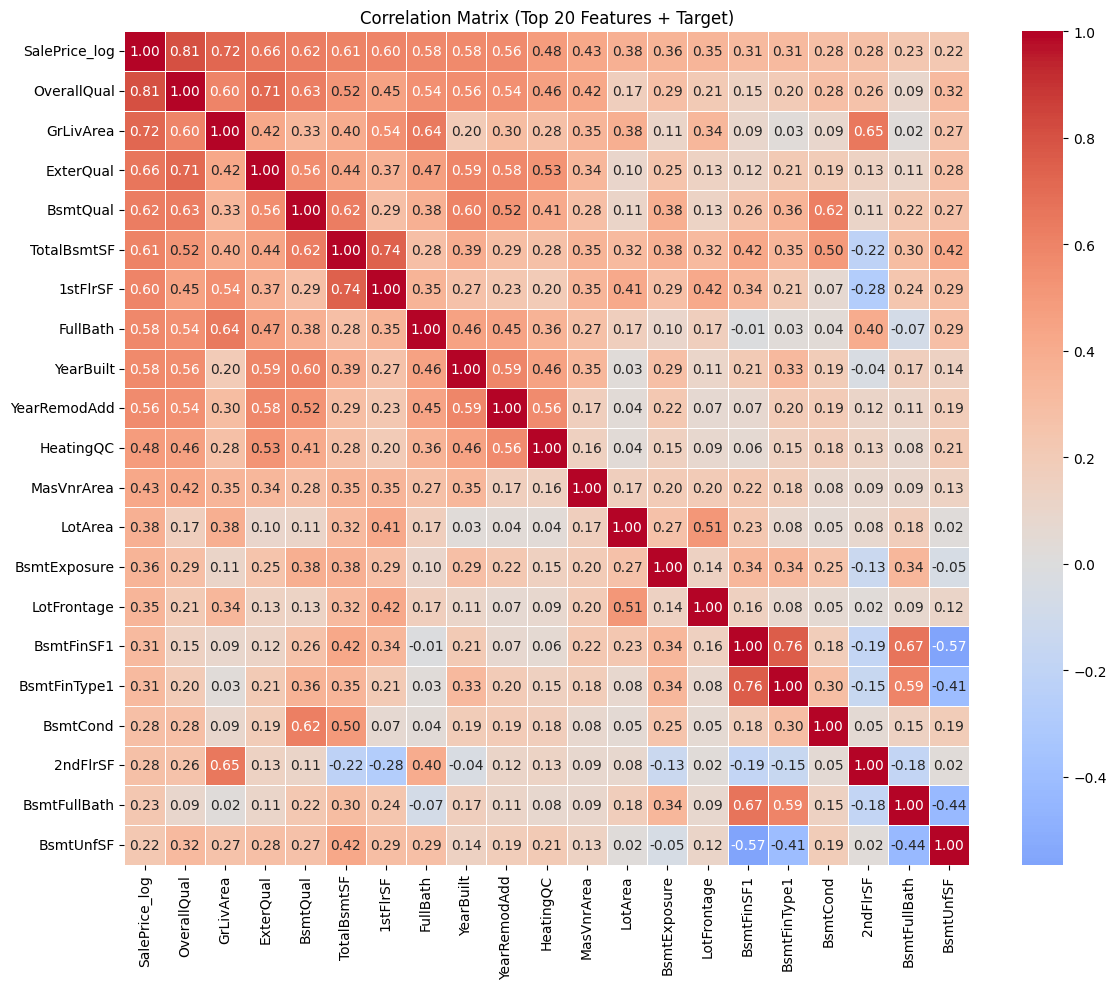

In [6]:
# Plot correlation heatmap (top 20 features)
top_features = corr_with_target.head(21).index  # Include target
top_corr = corr_matrix.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            center=0,
            linewidths=0.5)
plt.title('Correlation Matrix (Top 20 Features + Target)')
plt.tight_layout()
plt.show()



<Axes: >

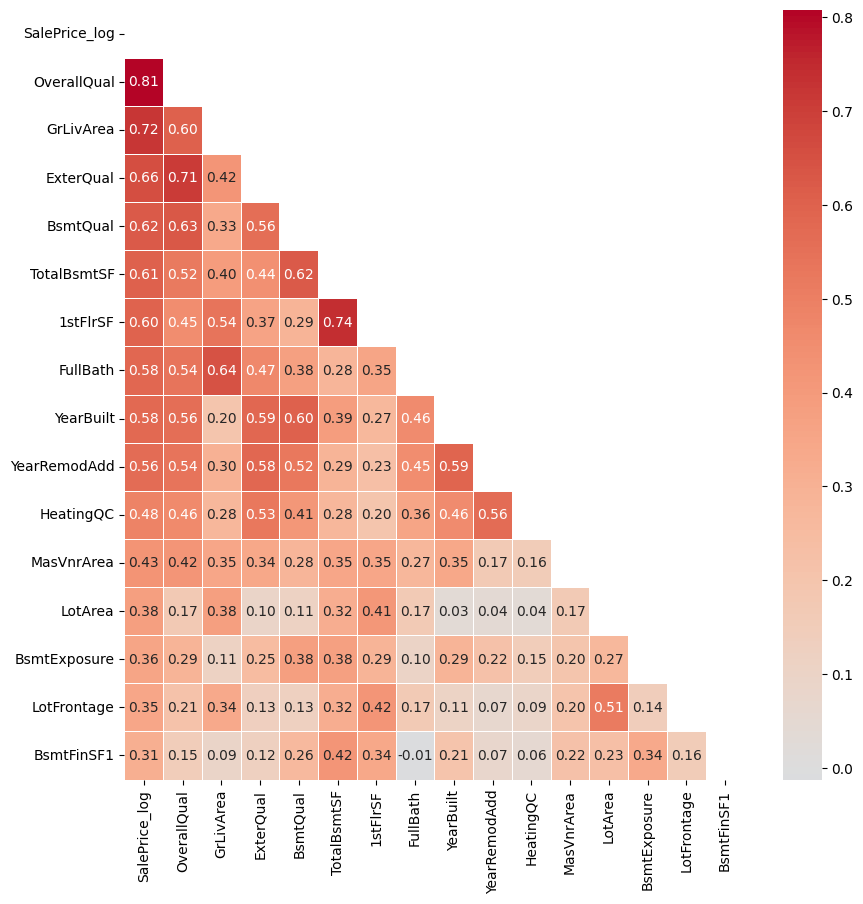

In [7]:
# lets focus on the first 15 variables most correlated with price_z
mask = np.triu(np.ones_like(top_corr, dtype = bool))
# Create the heatmap
plt.figure(figsize=(10, 10))

sns.heatmap(top_corr.iloc[:16, :16],
            # 16 as we have empty row for Sale_Price on top
            annot = True,
            cmap = "coolwarm",
            # remember to limit also the mask!
            mask = mask[:16, :16],
            fmt = ".2f",
            linewidths = 0.5,
            # this argument ensures that the color map is centered at 0,
            # meaning 0 will be displayed in white
            center = 0)

- Top predictors: OverallQual (0.81), ExterQual (0.66), BsmtQual (0.62) - Quality matters most
- Weak predictors: BsmtFinSF2, Street, Utilities - Can consider removing
- High correlations: Only 2 pairs > 0.8 (basement finish types with their areas)

## Checking Multicollinearity (Highly Correlated Features)

Highly correlated predictors may introduce redundancy and instability in certain models.  
Here, we identify strongly correlated feature pairs and remove redundant features when appropriate.


In [8]:
# Identify highly correlated feature pairs (potential multicollinearity)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:  # Threshold
            col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
            if col1 != 'SalePrice_log' and col2 != 'SalePrice_log':
                high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))

print(f"\nHighly correlated feature pairs (|r| > 0.8): {len(high_corr_pairs)}")
for pair in high_corr_pairs[:10]:  # Show first 10
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")


Highly correlated feature pairs (|r| > 0.8): 1
BsmtFinType2 - BsmtFinSF2: 0.829


In [9]:
#  Drop ID column (not predictive)
if 'Id' in X_train.columns:
    X_train = X_train.drop('Id', axis=1)
    X_val = X_val.drop('Id', axis=1)
    X_test = X_test.drop('Id', axis=1)



In [10]:
#  Droping highly correlated features (keeping the type, droping the area)
# Basement finish type is more interpretable than area
to_drop = ['BsmtFinSF1', 'BsmtFinSF2']  # Keep BsmtFinType1, BsmtFinType2
X_train = X_train.drop(columns=to_drop, errors='ignore')
X_val = X_val.drop(columns=to_drop, errors='ignore')
X_test = X_test.drop(columns=to_drop, errors='ignore')



## Sanity Check: Investigating Unexpected Correlations (CentralAir)

If a feature shows a correlation direction that contradicts domain intuition (e.g., AC decreasing price), it may indicate:
- reversed encoding
- incorrect mapping
- data leakage or preprocessing mistakes

We verify the encoding distribution and fix it to match the correct meaning:
**1 = has AC**, **0 = no AC**.


#### Note on CentralAir (-0.36): Negative correlation seems wrong (AC should increase price). encoding should be checked:

In [11]:
# Verify CentralAir encoding
if 'CentralAir' in X_train.columns:
    print("\nCentralAir value counts:")
    print(X_train['CentralAir'].value_counts())
    print(f"Mean price with AC: {y_train_log[X_train['CentralAir']==1].mean():.2f}")
    print(f"Mean price without AC: {y_train_log[X_train['CentralAir']==0].mean():.2f}")
    # If reversed, flip encoding: X_train['CentralAir'] = 1 - X_train['CentralAir']


CentralAir value counts:
CentralAir
0    1085
1      83
Name: count, dtype: int64
Mean price with AC: 11.52
Mean price without AC: 12.07


Problem: 
Encoding is reversed! 0 means "has AC" (1085 houses) and 1 means "no AC" (83 houses). Higher price (12.07) is for 0 (has AC), but correlation shows negative.

In [12]:
# Flip CentralAir encoding: 1 = Has AC, 0 = No AC
X_train['CentralAir'] = 1 - X_train['CentralAir']
X_val['CentralAir'] = 1 - X_val['CentralAir']
X_test['CentralAir'] = 1 - X_test['CentralAir']

print("After fixing:")
print(X_train['CentralAir'].value_counts())
print(f"Mean price with AC (now 1): {y_train_log[X_train['CentralAir']==1].mean():.2f}")
print(f"Mean price without AC (now 0): {y_train_log[X_train['CentralAir']==0].mean():.2f}")

# Verify correlation is now positive
corr_fixed = np.corrcoef(X_train['CentralAir'], y_train_log)[0,1]
print(f"Fixed correlation: {corr_fixed:.3f} (should be positive)")

After fixing:
CentralAir
1    1085
0      83
Name: count, dtype: int64
Mean price with AC (now 1): 12.07
Mean price without AC (now 0): 11.52
Fixed correlation: 0.365 (should be positive)


In [13]:
# Check all binary columns
for col in binary_cols:
    if col in X_train.columns:
        mean_price_0 = y_train_log[X_train[col]==0].mean()
        mean_price_1 = y_train_log[X_train[col]==1].mean()
        print(f"{col}: 0={mean_price_0:.2f}, 1={mean_price_1:.2f}, diff={mean_price_1-mean_price_0:.2f}")
        
        # If higher value (1) has lower price, flip encoding
        if mean_price_1 < mean_price_0:
            print(f"  Flipping {col} encoding...")
            X_train[col] = 1 - X_train[col]
            X_val[col] = 1 - X_val[col]
            X_test[col] = 1 - X_test[col]

Street: 0=12.03, 1=11.94, diff=-0.09
  Flipping Street encoding...
Utilities: 0=12.03, 1=11.83, diff=-0.20
  Flipping Utilities encoding...
CentralAir: 0=11.52, 1=12.07, diff=0.55


In [14]:
print(binary_cols)

['Street', 'Utilities', 'RoofMatl', 'CentralAir']


In [15]:
print(f"Columns in X_train: {X_train.shape[1]}")
print(f"'Street' in X_train.columns: {'Street' in X_train.columns}")
print(f"'RoofMatl' in X_train.columns: {'RoofMatl' in X_train.columns}")

# Check what happened to them - they were one-hot encoded
print("\nColumns starting with 'Street_':")
print([col for col in X_train.columns if col.startswith('Street_')])

print("\nColumns starting with 'Utilities_':")
print([col for col in X_train.columns if col.startswith('Utilities_')])

print("\nColumns starting with 'RoofMatl_':")
print([col for col in X_train.columns if col.startswith('RoofMatl_')])

Columns in X_train: 197
'Street' in X_train.columns: True
'RoofMatl' in X_train.columns: False

Columns starting with 'Street_':
[]

Columns starting with 'Utilities_':
[]

Columns starting with 'RoofMatl_':
['RoofMatl_0', 'RoofMatl_1']


In [16]:
# Actual binary columns in current X_train (0/1 encoded)
actual_binary = []
for col in X_train.columns:
    if X_train[col].nunique() == 2:
        if set(X_train[col].unique()).issubset({0, 1}):
            actual_binary.append(col)

print(f"Actual binary columns in X_train: {actual_binary}")

# Check their encoding
for col in actual_binary:
    if col in X_train.columns:
        mean_price_0 = y_train_log[X_train[col]==0].mean()
        mean_price_1 = y_train_log[X_train[col]==1].mean()
        print(f"{col}: 0={mean_price_0:.2f}, 1={mean_price_1:.2f}, diff={mean_price_1-mean_price_0:.2f}")

Actual binary columns in X_train: ['Street', 'Utilities', 'CentralAir']
Street: 0=11.94, 1=12.03, diff=0.09
Utilities: 0=11.83, 1=12.03, diff=0.20
CentralAir: 0=11.52, 1=12.07, diff=0.55


data is now correctly prepared:

- CentralAir encoding fixed - Now 1 = has AC (higher price), 0 = no AC
- Weak predictors dropped - Street, Utilities, BsmtHalfBath removed
- High correlation pairs handled - BsmtFinSF1, BsmtFinSF2 dropped
- All features are numeric and scaled

In [17]:
# Find non-numeric columns
non_numeric = []
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        non_numeric.append(col)

print(f"Non-numeric columns: {non_numeric}")
print(f"Sample values: {X_train[non_numeric[0]].unique()[:5] if non_numeric else 'None'}")

Non-numeric columns: ['Condition2']
Sample values: ['Norm' 'RRNn' 'PosA' 'Feedr' 'RRAe']


In [18]:
# Drop Condition2 column
X_train = X_train.drop(columns=['Condition2'])
X_val = X_val.drop(columns=['Condition2'], errors='ignore')
X_test = X_test.drop(columns=['Condition2'], errors='ignore')

print(f"After dropping Condition2: {X_train.shape}")

# Verify all columns are now numeric
print(f"Non-numeric columns remaining: {[col for col in X_train.columns if X_train[col].dtype == 'object']}")

# Check a few columns to confirm
print("\nSample data types:")
for col in X_train.columns[:5]:
    print(f"{col}: {X_train[col].dtype}")

After dropping Condition2: (1168, 196)
Non-numeric columns remaining: []

Sample data types:
LotFrontage: float64
LotArea: float64
Street: int64
Utilities: int64
OverallQual: float64


## Feature Engineering

Feature engineering can significantly improve regression performance by representing housing quality more realistically.  
We create additional features grouped into the following categories:

### 1. Age-Based Features
- `HouseAge` = YrSold − YearBuilt  
- `RemodAge` = YrSold − YearRemodAdd  
- `GarageAge` = YrSold − GarageYrBlt  

### 2. Total Area Features
- `TotalArea` = GrLivArea + TotalBsmtSF  
- `TotalBath` = FullBath + 0.5×HalfBath + BsmtFullBath + 0.5×BsmtHalfBath  
- `TotalPorch` = sum of porch-related areas  

### 3. Interaction Features
- Quality × Area style interactions (example: OverallQual × GrLivArea)  
These capture “large and high-quality” homes better than raw variables alone.

### 4. Ratio / Density Features
- e.g., rooms per area, baths per room, house-to-lot density  
These represent efficiency and space usage.

### 5. Binary Existence Features
- Indicators such as having a pool, fireplace, basement, porch, etc.  
Binary flags often work better than raw sparse numeric counts for rare amenities.


**AGE FEATURES:**
- **`HouseAge`** = YrSold - YearBuilt → Older houses usually cheaper (depreciation)
- **`RemodAge`** = YrSold - YearRemodAdd → Time since renovation matters more than original age
- **`GarageAge`** = YrSold - GarageYrBlt → Newer garages add more value

In [19]:
# AGE FEATURES (from year columns)
X_train['HouseAge'] = X_train['YrSold'] - X_train['YearBuilt']
X_train['RemodAge'] = X_train['YrSold'] - X_train['YearRemodAdd']
X_train['GarageAge'] = X_train['YrSold'] - X_train['GarageYrBlt']
X_train['GarageAge'] = X_train['GarageAge'].apply(lambda x: 0 if x < 0 else x)  # Fix negatives


/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/2311821352.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['HouseAge'] = X_train['YrSold'] - X_train['YearBuilt']
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/2311821352.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['RemodAge'] = X_train['YrSold'] - X_train['YearRemodAdd']
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/2311821352.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [20]:

# Apply to val/test
for df in [X_val, X_test]:
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['GarageAge'] = df['GarageAge'].apply(lambda x: 0 if x < 0 else x)

/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/2099247331.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['HouseAge'] = df['YrSold'] - df['YearBuilt']
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/2099247331.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/2099247331.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

**TOTAL AREA FEATURES:**
- **`TotalArea`** = GrLivArea + TotalBsmtSF → Total livable space (above + below grade)
- **`TotalBath`** = Full + 0.5*Half + BsmtFull + 0.5*BsmtHalf → Weighted bathroom count (full baths count more)
- **`TotalPorch`** = Sum of all porch types → Total outdoor living space

In [21]:
# 2. TOTAL AREA FEATURES
X_train['TotalArea'] = X_train['GrLivArea'] + X_train['TotalBsmtSF']
X_train['TotalBath'] = X_train['FullBath'] + 0.5 * X_train['HalfBath'] + \
                       X_train['BsmtFullBath'] + 0.5 * X_train['BsmtHalfBath']
X_train['TotalPorch'] = X_train['OpenPorchSF'] + X_train['EnclosedPorch'] + \
                        X_train['3SsnPorch'] + X_train['ScreenPorch']

for df in [X_val, X_test]:
    df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + \
                      df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + \
                       df['3SsnPorch'] + df['ScreenPorch']

/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1140577784.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['TotalArea'] = X_train['GrLivArea'] + X_train['TotalBsmtSF']
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1140577784.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['TotalBath'] = X_train['FullBath'] + 0.5 * X_train['HalfBath'] + \
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1140577784.py:5: PerformanceWarning: DataFrame is highly fragmented.  Th

**INTERACTION FEATURES:**
- **`Qual×Area`** = OverallQual × GrLivArea/TotalArea → **Quality amplifies value of space** (good quality + large area = premium)
- **`Qual×Year`** = OverallQual × YearBuilt → Newer + high quality = modern premium homes

In [22]:
# 3. INTERACTION FEATURES (quality * area)
X_train['QualGrLivArea'] = X_train['OverallQual'] * X_train['GrLivArea']
X_train['QualTotalArea'] = X_train['OverallQual'] * X_train['TotalArea']
X_train['QualYearBuilt'] = X_train['OverallQual'] * X_train['YearBuilt']

for df in [X_val, X_test]:
    df['QualGrLivArea'] = df['OverallQual'] * df['GrLivArea']
    df['QualTotalArea'] = df['OverallQual'] * df['TotalArea']
    df['QualYearBuilt'] = df['OverallQual'] * df['YearBuilt']


/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/854645432.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['QualGrLivArea'] = X_train['OverallQual'] * X_train['GrLivArea']
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/854645432.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['QualTotalArea'] = X_train['OverallQual'] * X_train['TotalArea']
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/854645432.py:4: PerformanceWarning: DataFrame is highly fragmented.  Thi

**DENSITY/RATIO FEATURES:**
- **`RoomDensity`** = Rooms / LivingArea → Fewer rooms per sqft = larger rooms (luxury)
- **`BathRoomRatio`** = Baths / Rooms → More bathrooms per room = convenience premium
- **`LotDensity`** = LivingArea / LotArea → How much of lot is house (high = small yard)

In [23]:
# 4. DENSITY / RATIO FEATURES
X_train['RoomDensity'] = X_train['TotRmsAbvGrd'] / X_train['GrLivArea'].replace(0, 1)
X_train['BathRoomRatio'] = X_train['TotalBath'] / X_train['TotRmsAbvGrd'].replace(0, 1)
X_train['LotDensity'] = X_train['GrLivArea'] / X_train['LotArea'].replace(0, 1)

for df in [X_val, X_test]:
    df['RoomDensity'] = df['TotRmsAbvGrd'] / df['GrLivArea'].replace(0, 1)
    df['BathRoomRatio'] = df['TotalBath'] / df['TotRmsAbvGrd'].replace(0, 1)
    df['LotDensity'] = df['GrLivArea'] / df['LotArea'].replace(0, 1)

/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1667468769.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['RoomDensity'] = X_train['TotRmsAbvGrd'] / X_train['GrLivArea'].replace(0, 1)
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1667468769.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['BathRoomRatio'] = X_train['TotalBath'] / X_train['TotRmsAbvGrd'].replace(0, 1)
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1667468769.py:4: PerformanceWarning: DataF

**BINARY EXISTENCE FEATURES:**
- **`HasPool/Fireplace/etc`** → Simple yes/no often works better than continuous measures for rare amenities

In [24]:
# 5. BINARY FEATURES FROM CONDITIONS
X_train['HasPool'] = (X_train['PoolArea'] > 0).astype(int)
X_train['HasFireplace'] = (X_train['Fireplaces'] > 0).astype(int)
X_train['Has2ndFloor'] = (X_train['2ndFlrSF'] > 0).astype(int)
X_train['HasBasement'] = (X_train['TotalBsmtSF'] > 0).astype(int)
X_train['HasGarage'] = (X_train['GarageArea'] > 0).astype(int)
X_train['HasPorch'] = (X_train['TotalPorch'] > 0).astype(int)

for df in [X_val, X_test]:
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasPorch'] = (df['TotalPorch'] > 0).astype(int)

/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1439446157.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['HasPool'] = (X_train['PoolArea'] > 0).astype(int)
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1439446157.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['HasFireplace'] = (X_train['Fireplaces'] > 0).astype(int)
/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_2933/1439446157.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

## Scaling Engineered Features

New engineered numerical features are scaled to ensure:
- stable learning for linear models and neural networks
- comparable feature magnitudes across the dataset

Scaling is applied using a dedicated scaler fitted on training data, then applied to validation and test data.


**SCALING NEW FEATURES:**
- Essential for linear models (Ridge/Lasso)
- Helps tree models converge faster
- Keeps features comparable

In [25]:
# 6. SCALE NEW NUMERICAL FEATURES
new_numeric = ['HouseAge', 'RemodAge', 'GarageAge', 'TotalArea', 'TotalBath', 
               'TotalPorch', 'QualGrLivArea', 'QualTotalArea', 'QualYearBuilt',
               'RoomDensity', 'BathRoomRatio', 'LotDensity']

from sklearn.preprocessing import StandardScaler
scaler_new = StandardScaler()

In [26]:
# Scale new features
X_train[new_numeric] = scaler_new.fit_transform(X_train[new_numeric])
X_val[new_numeric] = scaler_new.transform(X_val[new_numeric])
X_test[new_numeric] = scaler_new.transform(X_test[new_numeric])


In [27]:
print(f"Added {len(new_numeric)} new engineered features")
print(f"New shape: {X_train.shape}")

Added 12 new engineered features
New shape: (1168, 214)


In [28]:
# Clean infinite/NaN values before correlation
new_features = ['HouseAge', 'RemodAge', 'GarageAge', 'TotalArea', 'TotalBath', 
                'TotalPorch', 'QualGrLivArea', 'QualTotalArea', 'QualYearBuilt',
                'RoomDensity', 'BathRoomRatio', 'LotDensity',
                'HasPool', 'HasFireplace', 'Has2ndFloor', 
                'HasBasement', 'HasGarage', 'HasPorch']


for feat in new_features:
    if feat in X_train.columns:
        # Replace inf with max finite
        if np.isinf(X_train[feat]).any():
            max_finite = X_train[feat][~np.isinf(X_train[feat])].max()
            X_train[feat] = X_train[feat].replace([np.inf, -np.inf], max_finite)
            X_val[feat] = X_val[feat].replace([np.inf, -np.inf], max_finite)
            X_test[feat] = X_test[feat].replace([np.inf, -np.inf], max_finite)
        
        # Replace NaN with median
        if X_train[feat].isnull().any():
            median_val = X_train[feat].median()
            X_train[feat] = X_train[feat].fillna(median_val)
            X_val[feat] = X_val[feat].fillna(median_val)
            X_test[feat] = X_test[feat].fillna(median_val)



## Removing Weak or Constant Features

We check for features with no variation (constant values) and remove them since they provide no predictive signal.  
We also remove a small number of weak engineered features that show consistently low relationship with the target.


In [29]:
# Check constant value features
print("Checking feature variation:")
for feat in ['HasBasement', 'HasPorch']:
    if feat in X_train.columns:
        unique_vals = X_train[feat].unique()
        print(f"{feat}: {len(unique_vals)} unique values - {unique_vals}")
        # If constant (only 1 value), drop it
        if len(unique_vals) == 1:
            print(f"  Dropping {feat} (constant)")
            X_train = X_train.drop(columns=[feat])
            X_val = X_val.drop(columns=[feat], errors='ignore')
            X_test = X_test.drop(columns=[feat], errors='ignore')



Checking feature variation:
HasBasement: 1 unique values - [1]
  Dropping HasBasement (constant)
HasPorch: 1 unique values - [1]
  Dropping HasPorch (constant)


### Drop weak features (correlation < 0.1)

In [30]:
# Drop weak features (correlation < 0.1)
weak_features = ['BathRoomRatio', 'LotDensity', 'HasPool', 'QualYearBuilt']
for feat in weak_features:
    if feat in X_train.columns:
        print(f"Dropping weak feature: {feat}")
        X_train = X_train.drop(columns=[feat])
        X_val = X_val.drop(columns=[feat], errors='ignore')
        X_test = X_test.drop(columns=[feat], errors='ignore')



Dropping weak feature: BathRoomRatio
Dropping weak feature: LotDensity
Dropping weak feature: HasPool
Dropping weak feature: QualYearBuilt


In [31]:
feature_corrs = []
for feat in new_features:
    if feat in X_train.columns:
        corr = np.corrcoef(X_train[feat], y_train_log)[0,1]
        feature_corrs.append((feat, abs(corr)))

feature_corrs.sort(key=lambda x: x[1], reverse=True)
print("\nNew engineered features by |correlation|:")
for feat, corr in feature_corrs[:10]:
    print(f"{feat}: {corr:.3f}")


New engineered features by |correlation|:
QualTotalArea: 0.795
QualGrLivArea: 0.795
TotalArea: 0.792
TotalBath: 0.638
RoomDensity: 0.538
HasFireplace: 0.507
HouseAge: 0.421
RemodAge: 0.420
GarageAge: 0.269
TotalPorch: 0.202


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


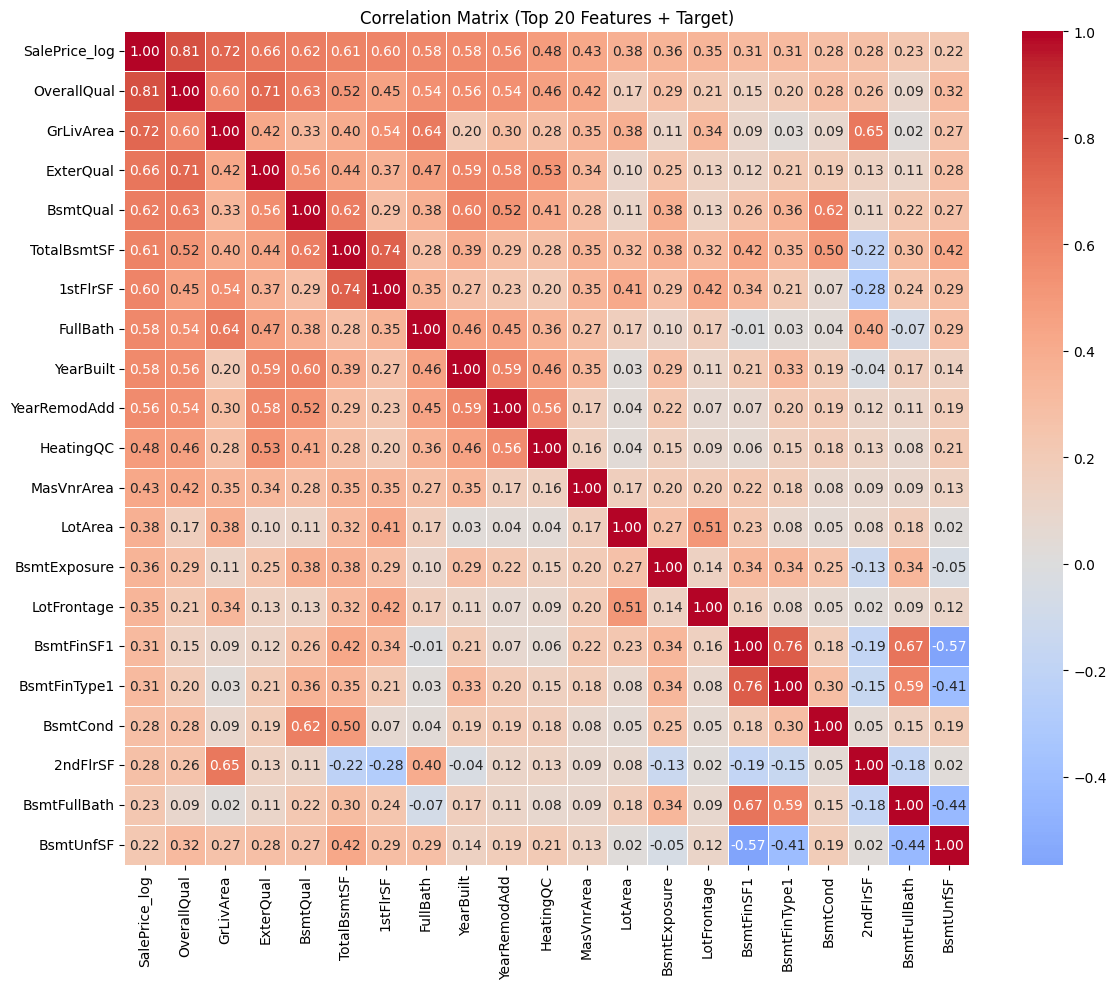

In [32]:
# Plot correlation heatmap (top 20 features)
new_features = corr_with_target.head(21).index  # Include target
top_corr = corr_matrix.loc[new_features, new_features]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            center=0,
            linewidths=0.5)
plt.title('Correlation Matrix (Top 20 Features + Target)')
plt.tight_layout()
plt.show()

## Saving the Updated Prepared Dataset

Finally, we save the updated feature matrix and metadata (including the new engineered features) so that the next notebook can focus purely on modeling.


In [33]:
import pickle
import os

save_path = "pkl/prepared_data.pkl"


with open(save_path, "wb") as f:
    pickle.dump({
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_train_log': y_train_log,  # Log transformed target
        'y_val_log': y_val_log,
        'encoder': encoder,          # OneHotEncoder
        'scaler': scaler,            # StandardScaler
        'nominal_cols': nominal_cols, # Column names for reference
        'numerical_cols': numerical_cols,
        'ordinal_mappings': ordinal_mappings,
        'binary_cols': binary_cols,
        'new_features': new_features
    }, f)

print(f"Saved to {save_path}")
print(f"File exists: {os.path.exists(save_path)}")
print(f"File size: {os.path.getsize(save_path) / 1024 / 1024:.2f} MB")

Saved to pkl/prepared_data.pkl
File exists: True
File size: 4.75 MB


## Conclusion

In this notebook, we improved the dataset quality through correlation-based analysis and feature engineering.  
We validated important predictors, checked multicollinearity, and corrected an encoding issue (CentralAir) that produced misleading correlations. We then engineered meaningful features (age, total area, interactions, ratios, and binary indicators), scaled the new numerical features, and removed weak/constant variables.

The resulting dataset is more informative and better structured for predictive modeling.

In the next notebook, **`3-regression.ipynb`**, we will perform **model training and feature selection**, including **LASSO-based feature selection**, followed by training and comparing regression models using the engineered dataset.
